## Cristian Alejandro CHÁVEZ BECERRA

In [2]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
!pip install munkres
from munkres import Munkres
from tqdm import tqdm

**I - Data generation and manipulation**

In this practical session we will use two datasets :
- a first simple one, to understand how the SPA iterations work ;
- a real hyperspectral one, called urban.
Urban is one of the most widely used hyperspectral data used for hyperspectral unmixing studies. There are 307 x 307 pixels, each of which corresponds to a 2 x 2 m2 area. There are 210 wavelengths ranging from 400 nm  to 2500 nm, resulting in a spectral resolution of 10 nm. After the channels 1--4, 76, 87, 101--111, 136--153 and 198--210 are removed (due to dense water vapor and atmospheric effects), we obtain 162  channels.
Interestingly enough, a ground truth have been established. The one we will use contains 6 endmembers (i.e. sources).

**1) Simple dataset**

We propose to generate a very simple dataset, for visual purposes, as follows:
- the mixing matrix **A** will be a m x n matrix with its coefficients generated randomly in [0,10]. When you obtain such a realisation, verify that **A** is not too badly conditioned.
- the source matrix **S** will be a n x t matrix with random coefficients in [0,1] but will be scalled so that the l1-norm of each of its columns sum to 1.
- There will be no noise.

Condition number of A: 26.303623853090375


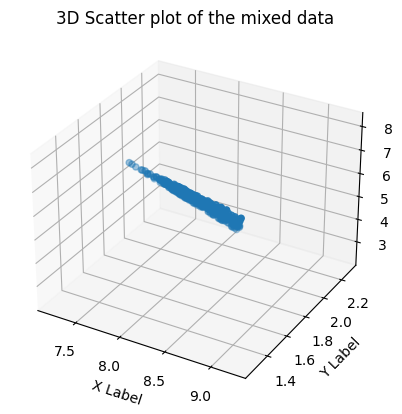

In [3]:
# TO DO : generate A according to the above description.
# TO DO : compute the condition number of A. What would be the issue with an ill-conditioned mixing matrix?
# TO DO : generate S according to the above conditions.
# TO DO : generate X with a linear mixing

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parameters
n = 3
m = 3
t = 500

# Generate the mixing matrix A
A_toy = np.random.uniform(0, 10, (m, n))

# Compute the condition number of A
condition_number = np.linalg.cond(A_toy)
print(f"Condition number of A: {condition_number}")

# Generate the source matrix S
S_toy = np.random.rand(n, t)
S_toy /= np.sum(S_toy, axis=0)  # Scale columns to have l1-norm equal to 1

# Generate the mixed data matrix X
X_toy = np.dot(A_toy, S_toy)

# Plot the data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_toy[0, :], X_toy[1, :], X_toy[2, :])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.title('3D Scatter plot of the mixed data')
plt.show()

<Figure size 640x480 with 0 Axes>

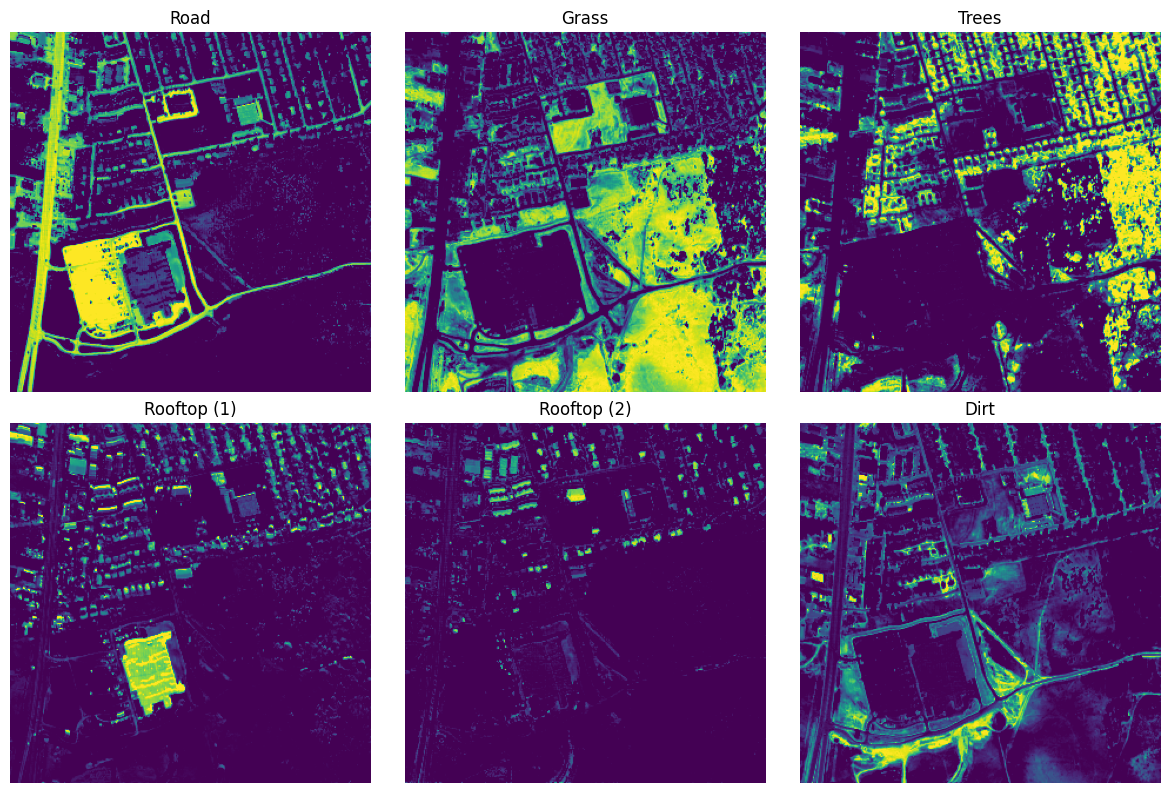

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sci

# Load the hyperspectral data
data = sci.loadmat('Urban.mat')
X = data['X'].astype(float)  # Please take care that the data matrix must be cast to float in Python, for subsequent operations

# Load the ground truth abundances
gt = sci.loadmat('end6_groundTruth.mat')
abundances = gt['A']  # Here A is a dummy variable, don't pay attention to it. The abundances are S^*.

# Dimensions
nCol = 307
nRow = 307

plt.figure()
# TO DO: try to interpret the abundances that you see. Hint: the 6 sources are usually called ['Grass','Road','Rooftop (2)','Dirt','Trees','Rooftop (1)']. Associate a name to each endmember.
endmember_names = ['Road','Grass', 'Trees', 'Rooftop (1)', 'Rooftop (2)' , 'Dirt']  # Names of the endmembers

# Plot the abundance maps
plt.figure(figsize=(12, 8))
for ii in range(6):
    ax = plt.subplot(2, 3, ii + 1)
    ax.imshow(abundances[ii, :].reshape(nCol, nRow), cmap='viridis')
    ax.set_title(endmember_names[ii])
    ax.axis('off')

plt.tight_layout()
plt.show()



**2) Real hyperspectral data set**

First, upload in your working environment the two files Urban.mat and end6_groundTruth.mat, which can be found at https://partage.imt.fr/index.php/s/QEPMQa7KZsc7sAy

Here, we will use the "Urban" dataset:
- The data matrix **X = AS + N**, which has been acquired by a true sensor ;
- The groundtruth **S_gt**, which corresponds to the "true" abundances (sur groundtruth can for instance be found by on earth geological inquiries). Note that having access to **S_gt** is exceptional: for most other datasets, it would be unknown.

- TO DO : is the near separable (aka pure pixel) assumption fulfilled on this dataset? Explain why.

- ANSWER :

The near separable assumption suggests that within the dataset, there are pixels dominated by individual endmembers, known as 'pure' pixels. Each endmember, such as 'Grass', 'Road', 'Rooftop (2)', 'Dirt', 'Trees', and 'Rooftop (1)', has areas within the images where it is predominantly present, with abundances exceeding 99.9%. This indicates the existence of 'pure' pixels corresponding to each endmember, thus confirming the fulfillment of the near separable assumption. And in fact, we can verify in the dataset pixels with abundances bigger than 0.999 for each endmember

- TO DO : we have access to the abundance **S_gt** groundtruth but not to the endmembers **A_gt**. Use your above answer to the to explain how the following code finds the endmembers.
In particular, explain the use of the mean function (adding some plots to your report might be beneficial here).


```python
endmembers = np.zeros((162, 6)):
```
Initializes an array to store the endmembers. It has 162 rows (representing the spectral bands) and 6 columns (representing the number of endmembers).

```python
for ii in range(6):
```  
Iterates over each endmember.

```python
ind = np.where(abundances[ii] > 0.999)[0]
```
Finds the indices of pixels where the abundance of the current endmember (ii) is greater than 0.999. These pixels are considered as "pure pixels" dominated by the current endmember.

```python
allPP = X[:, ind]
```
Extracts all spectral signatures of the pure pixels corresponding to the current endmember.

```python
endmembers[:, ii] = np.mean(allPP, axis=1)
```
Calculates the endmember spectrum by taking the mean of the spectral signatures of the pure pixels along the spectral dimension (axis=1). This results in a single spectrum for each endmember.

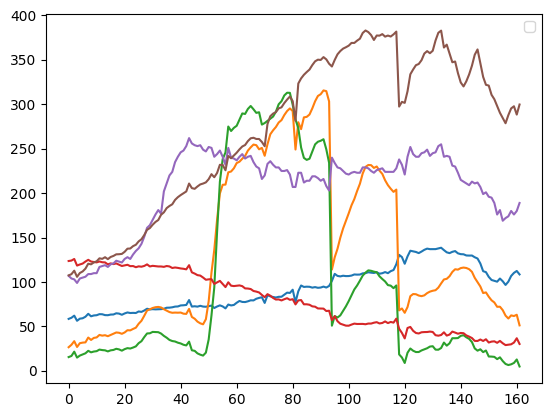

In [9]:
endmembers= np.zeros((162,6))

for ii in range(6):
    ind = np.where(abundances[ii] > 0.999)[0]
    allPP = X[:,ind]
    endmembers[:,ii] = np.mean(allPP,axis=1)


plt.figure()
plt.legend(endmember_names)
plt.plot(endmembers)

**II - Near separable algorithm**

We will here implement the SPA (greedy) near-separable NMF algorithm and look at its practical efficiency.

1) Recall what near-separable NMF is.

**Answer**:

Near-Separable Non-Negative Matrix Factorization (NMF) is a variant of the traditional NMF algorithm designed to handle hyperspectral data. In near-separable NMF, it is assumed that the data matrix can be represented as the product of two matrices: a mixing matrix \( A \) and an abundance matrix \( S \), with the additional constraint that each column of \( S \) corresponds to a pure pixel or a combination of pure pixels. The near-separable assumption states that for each endmember, there exists at least one pixel in the data that contains only that endmember, making it a 'pure' pixel. This assumption allows for the efficient extraction of endmembers from hyperspectral data, which is crucial for applications such as target detection and classification.

2) Implement the SPA algorithm

In [10]:
import numpy as np

def simpleSPA(Xin, r, optDisp=False):
    X = Xin.copy()
    n_pixels = X.shape[1]
    K = np.zeros(r, dtype=int)

    for ii in range(r):
        R = X - np.dot(X[:, K[:ii]], np.linalg.pinv(X[:, K[:ii]])) @ X
        purity = np.linalg.norm(R, axis=0)
        new_endmember_index = np.argmax(purity)
        K[ii] = new_endmember_index
        if optDisp:
            print(f'Endmember {ii+1} selected: Index {new_endmember_index}, Purity {np.max(purity)}')

    return K

3) Launch the SPA algorithm on the toy example.

Plot the residual at each iteration of SPA.

How many sources can you at most extract ? Why ?

* Answer:  The maximum number of sources that can be extracted using SPA is limited by the number of endmembers in the dataset. In the toy example, the dataset has 3 endmembers, so the SPA algorithm can extract at most 3 sources. This limitation arises because SPA iteratively selects the endmembers that best explain the remaining variance in the data. Once all distinct endmembers are selected, further iterations of SPA will not yield new sources. Therefore, the maximum number of sources that can be extracted using SPA is equal to the number of distinct endmembers in the dataset.

In [11]:
K_SPA = simpleSPA(X_toy,3,optDisp = True)

Endmember 1 selected: Index 252, Purity 12.309887083285295
Endmember 2 selected: Index 123, Purity 3.8309958216136932
Endmember 3 selected: Index 309, Purity 0.7400795837542334


Iteration 1: Max residual 3.8309958216136932
Iteration 2: Max residual 0.7400795837542334
Iteration 3: Max residual 5.8410815908364745e-15


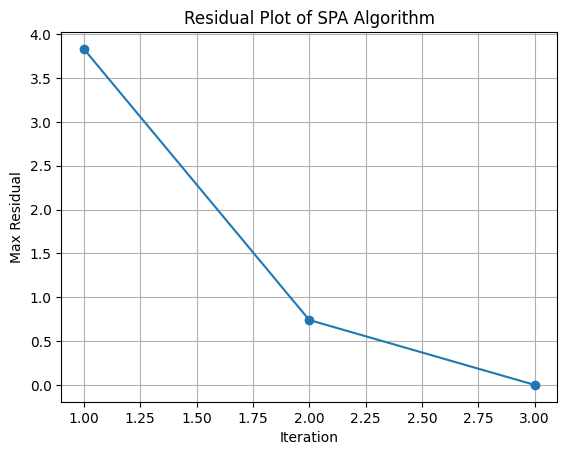

In [12]:
# Plot the residual at each iteration
residuals = []
for ii in range(1, 4):
    R = X_toy - np.dot(X_toy[:, K_SPA[:ii]], np.linalg.pinv(X_toy[:, K_SPA[:ii]])) @ X_toy
    residual = np.max(np.linalg.norm(R, axis=0))
    residuals.append(residual)
    print(f'Iteration {ii}: Max residual {residual}')

plt.plot(range(1, 4), residuals, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Max Residual')
plt.title('Residual Plot of SPA Algorithm')
plt.grid(True)
plt.show()

**4)** The code below enables to compute a separation metric to measure the separation accuracy of the BSS algorithms.

Use the evalCriterion function to assess the quality of SPA on the real dataset.

Plot the endmembers found by your algorithm. How good are they?

In [13]:
def norm_col(A):
    An = A.copy()
    type(An)
    for ii in range(np.shape(An)[1]):
        An[:,ii] = An[:,ii]/np.sqrt(np.sum(An[:,ii]**2));

    return An




def correctPerm(W0_en,W_en):
    # [WPerm,Jperm,err] = correctPerm(W0,W)
    # Correct the permutation so that W becomes the closest to W0.

    W0 = W0_en.copy()
    W = W_en.copy()

    W0 = norm_col(W0)
    W = norm_col(W)

    costmat = -W0.T@W; # Avec Munkres, il faut bien un -


    m = Munkres()
    Jperm = m.compute(costmat.tolist())

    WPerm = np.zeros(np.shape(W0))
    indPerm = np.zeros(np.shape(W0_en)[1])

    for ii in range(W0_en.shape[1]):
        WPerm[:,ii] = W_en[:,Jperm[ii][1]]
        indPerm[ii] = Jperm[ii][1]

    return WPerm,indPerm.astype(int)




def evalCriterion(W0_en,W_en):
    # W0 : true mixing matrix
    # W : estimated mixing matrix
    #
    # maxAngle : cosine of the maximum angle between the columns of W0 and W

    W0 = W0_en.copy()
    W = W_en.copy()

    W,indPerm = correctPerm(W0,W);

    W0 = norm_col(W0_en)
    W = norm_col(W)

    diff = W0.T@W;

    return np.mean(np.diag(diff));

Endmember 1 selected: Index 2512, Purity 9681.23535505671
Endmember 2 selected: Index 76537, Purity 4890.796228746163
Endmember 3 selected: Index 16799, Purity 3223.4154338254707
Endmember 4 selected: Index 17587, Purity 1062.7101282287742
Endmember 5 selected: Index 40058, Purity 816.9415819670081
Endmember 6 selected: Index 94073, Purity 699.4198247139168
Separation Accuracy of SPA: 0.9149174369799747


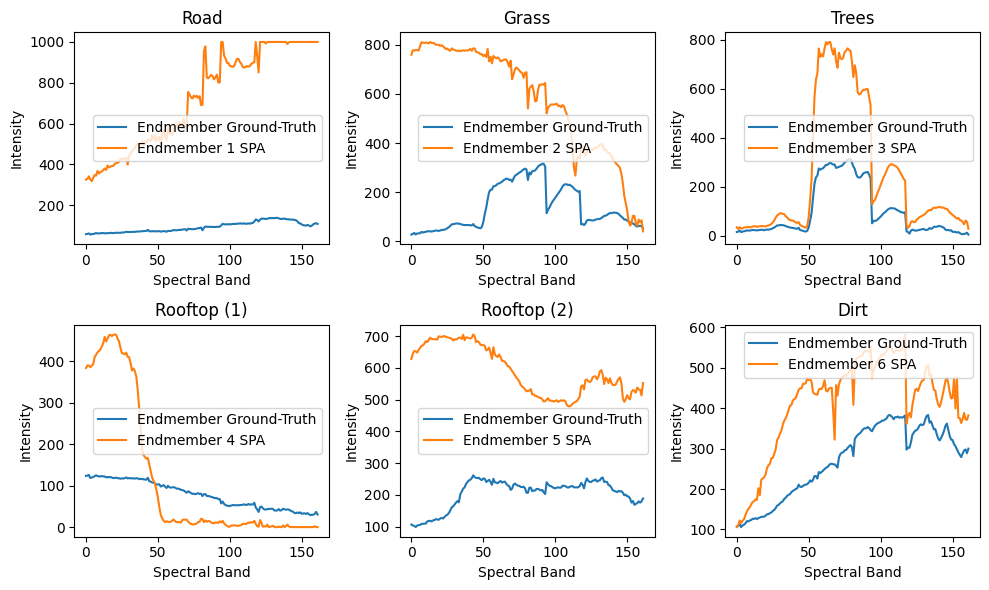

In [25]:
# Apply the SPA algorithm on the real dataset
K_SPA_real = simpleSPA(X, 6, optDisp=True)

# Extract endmembers based on the indices obtained from SPA
endmembers_SPA = X[:, K_SPA_real]

# Evaluate the separation accuracy of SPA
separation_accuracy = evalCriterion(endmembers, endmembers_SPA)
print(f'Separation Accuracy of SPA: {separation_accuracy}')

# Plot the endmembers found by SPA
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.plot(endmembers[:,i], label='Endmember Ground-Truth')
    plt.plot(endmembers_SPA[:, i], label=f'Endmember {i+1} SPA')
    plt.title(endmember_names[i])
    plt.xlabel('Spectral Band')
    plt.ylabel('Intensity')
    plt.legend()
plt.tight_layout()
plt.show()

**5)** (Bonus) The SPA algorithm gives you an estimation of the mixing matrix. Code an ISTA algorithm to obtain the corresponding sources (abundances). Plot them.

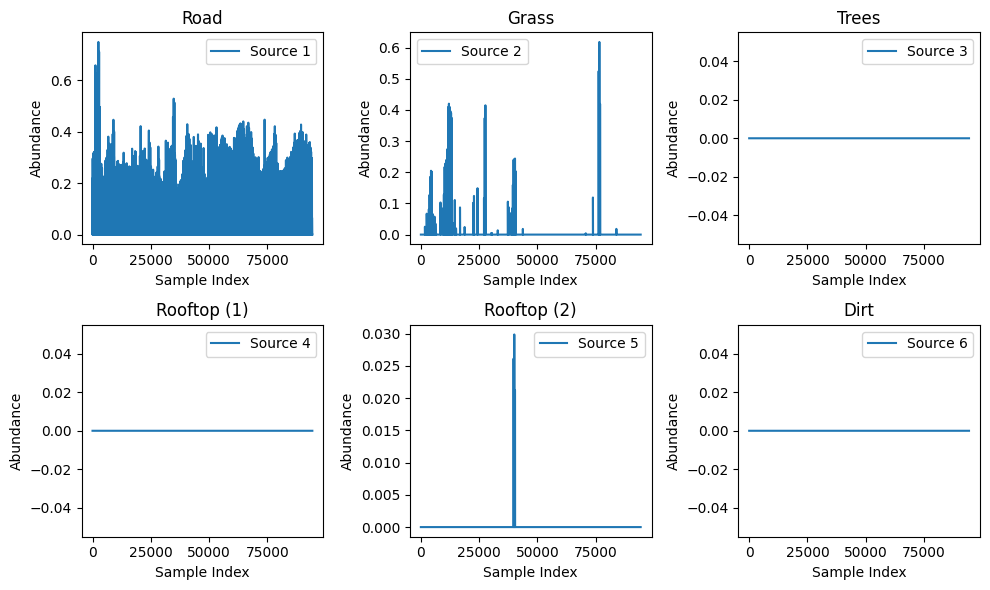

In [26]:
def ista(X, A, lambd=0.1, max_iter=100, tol=1e-4):
    S = np.zeros((A.shape[1], X.shape[1]))  # Initialize sources matrix
    L = np.linalg.norm(A, ord=2)**2  # Lipschitz constant for gradient step
    alpha = 1 / L  # Step size

    # Iterative Soft Thresholding Algorithm
    for i in range(max_iter):
        S_old = S.copy()  # Store previous iteration sources
        S = S + alpha * (A.T @ (X - A @ S))  # Gradient step
        S = np.sign(S) * np.maximum(0, np.abs(S) - lambd)  # Soft thresholding step
        # Check convergence
        if np.linalg.norm(S - S_old, ord='fro') < tol:
            break

    return S

# Apply ISTA algorithm to obtain sources
sources = ista(X, endmembers_SPA)

# Plot the sources obtained by ISTA
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.plot(sources[i], label=f'Source {i+1}')
    plt.title(endmember_names[i])
    plt.xlabel('Sample Index')
    plt.ylabel('Abundance')
    plt.legend()
plt.tight_layout()
plt.show()


**III - PLAIN NMF**

In this part we use the PALM algorithm to perform plain NMF. Of course, if you already coded the PALM algorihtm with sparsity constriant in the previous TP, you can just adapt it.

This optimization scheme is simple but can provide decent separation results.

**1)** Write the cost function of plain NMF.

**Answer:** The cost function of plain Non-Negative Matrix Factorization (NMF)  involves minimizing the Frobenius norm of the difference between the original data matrix \( X \) and the reconstruction obtained from the product of the estimated mixing matrix \( W \) and the estimated sources matrix \( H \), subject to the non-negativity constraints:


$$ min_{W \geq 0, H \geq 0} ||X - WH||_F^2 $$


where:
- $ X $ is the original data matrix of size $ m \times n $,
- $ W $ is the estimated mixing matrix of size $ m \times r $,
- $ H $ is the estimated sources matrix of size $ r \times n $,
- $ r $ is the desired rank of the factorization,
- $ ||\cdot||_F $ denotes the Frobenius norm.

This cost function aims to find the optimal \( W \) and \( H \) matrices such that their product approximates the original data matrix \( X \) as closely as possible, while ensuring that all elements of \( W \) and \( H \) are non-negative. This optimization problem is commonly solved using algorithms like PALM (Proximal Alternating Linearized Minimization) or multiplicative update rules.


**2)** Implement the proximal operator of the nonnegativity constraint.

In [21]:
def prox_positive(S): #TO DO
    return np.maximum(0, S)

**3)** Implement the PALM algorithm to solve the plain NMF problem.

In [27]:
def PALM(X,n=2,nbIt = 100,Ainit=None,Sinit=None): # TO DO : reutiliser le PALM du TP precedent et l'adapter

    S_est = np.zeros((n,X.shape[1]))
    A_est = np.eye(X.shape[0],n)

    #Iterative Update
    for _ in tqdm(range(nbIt)):

      S_est = prox_positive(S_est + (0.9/(np.linalg.norm(A_est.T @ A_est)+1e-16))*(np.dot(A_est.T,(X - np.dot(A_est,S_est)))))
      A_est = prox_positive(A_est + (0.9/(np.linalg.norm(S_est @ S_est.T)+1e-16))*np.dot((X - np.dot(A_est,S_est)),S_est.T))

    return A_est,S_est

  # CORRECTION
A_est,S_est = PALM(X,n=6,nbIt = 500,Ainit=None,Sinit=None) # TO DO: modify the initialization


**4)**
Launch the PALM algorithm on the real hyperspectral dataset.

Can you find of a better initialization than the random one ?

Compare your result, both qualitatively and quantitatively, with the SPA algorithm. Explain the differences.

Plot the abundances.

**Answer**

For improved initialization, instead of relying on random values, we can leverage faster techniques such as PCA, SVD, or SPA. These methods can help by providing a starting point that is closer to the optimal solution. Another approach is to initialize the features as independent representations or set $A$ as an identity matrix and $S$ as a zero matrix. This strategy tends to enhance the evaluation metric of the algorithm.

While PALM qualitatively yields good results for the abundances, the images it produces are not as clear as the ground truth. Quantitatively, PALM performs similarly to SPA but often achieves slightly better scores. Despite this, PALM's slower performance and high sensitivity to initialization can be drawbacks.

SPA is computationally less complex and faster than PALM. However, it performs poorly when the near separability assumption is not met. PALM, being more versatile and capable of handling a wider range of scenarios, is generally more robust but at the cost of increased computation time and dependency on the initialization choice.

When evaluating the results, PALM demonstrates the ability to approximate the abundances for each endmember, showing similarities to the ground truth. However, the clarity of PALM's results does not match the original. Quantitatively, PALM slightly outperforms SPA, with an evaluation criterion of 0.9383 compared to SPA's 0.9149. Nevertheless, the marginal improvement in the evaluation criterion may not justify the significantly higher computation time of PALM, making its application less advantageous in this context.


Evaluation Criterion:  0.938370091951284


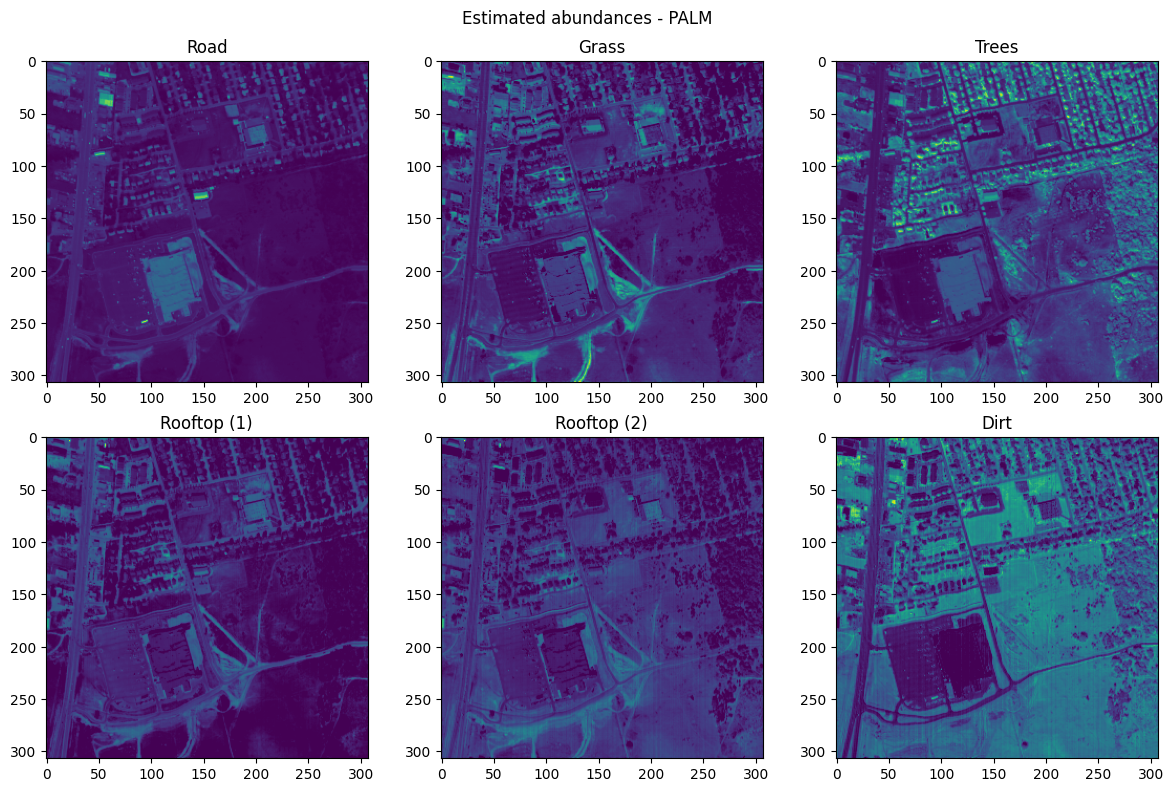

In [34]:
print("Evaluation Criterion: ", evalCriterion(endmembers, A_est))

plt.figure(figsize=(12, 8))
plt.suptitle('Estimated abundances - PALM')
for ii in range(6):
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(S_est[ii,:].reshape(nCol,nRow), cmap='viridis')
    ax.set_title(endmember_names[ii])
plt.tight_layout()
plt.show()

**IV - MINIMUM VOLUME NMF**

We finish this TP with the utilization of minimum volume NMF. As coding the corresponding algorithm is slightly above the objective of the classes, the code is fully given below.

In [35]:
def simplexProx(X,epsilon = 0):
#     Given X,  computes its projection Y onto the simplex

#       Delta = { x | x >= 0 and sum(x) <= 1 },

# that is, Y = argmin_z ||x-X||_2  such that z in S.

# If X is a matrix, is projects its columns onto Delta to generate Y.


# ****** Input ******
# X       : m-by-r matrix
# epsilon : r-by-1 vector, generally positive and taken = 0

# ****** Output ******
# Y       : the projected matrix


    if np.isscalar(epsilon) == 1:
        epsilon = epsilon*np.ones(np.shape(X)[1])

    Y = np.zeros(np.shape(X))

    for ii in range(np.shape(X)[1]): # The prox is separable over the columns of X
        x = X[:,ii].copy() # We work on each column separately
        xsort = np.sort(x) # We need to sort the x value to apply the dichotomy

        index_min=0 # Index values for the dichotomy
        index_max=len(x)-1;

        # mu s.t. x_i > mu-epsilon, forall i
        mu_min=xsort[0]+epsilon[ii] # mu is the parameter required for the projection

        min_sum=np.sum(x)-len(x)*mu_min

        if min_sum < 1:# If the vector already satisfies the sum to at most one constraint
            mu=(np.sum(x)-1.)/float(len(x))
            y=np.maximum(-epsilon[ii]*np.ones(len(x)), x-mu) # Element-wise max
            Y[:,ii]=y;
        else:
            # Use dichotomy for finding the optimal mu value
            stop = False
            it = 0
            while stop == False:
                it += 1

                cur_ind = int(np.round((float(index_min)+float(index_max)+1e-6)/2.))
                mu=xsort[cur_ind]+epsilon[ii]
                y=np.maximum(-epsilon[ii]*np.ones(len(x)), x-mu)

                val_constr = np.sum(y)
                if val_constr < 1.:
                    index_max=cur_ind # Because the objective is decreasing with mu and indMax > indMin
                elif val_constr > 1.:
                    index_min=cur_ind

                else: # We found the best mu
                    Y[:,ii]=y
                    stop = True


                if index_max == index_min + 1:# This is a stopping condition, as the constraint function is piecewise linear
                    stop = True


            mu_inf=xsort[index_min]+epsilon[ii];
            mu_sup=xsort[index_max]+epsilon[ii];
            constr_inf = np.sum(np.maximum(-epsilon[ii]*np.ones(len(x)),x-mu_inf))
            constr_sup = np.sum(np.maximum(-epsilon[ii]*np.ones(len(x)),x-mu_sup))

            slope=(constr_sup-constr_inf)/(mu_sup-mu_inf)
            mu_opt=(1.-constr_inf)/slope+mu_inf # Because the constraint function is piecewise linear

            # Compute the corresponding column of Y
            y=np.maximum(-epsilon[ii]*len(x), x-mu_opt)

            Y[:,ii]=y



    return Y




#%%
def FGM_MM_nonneg(A,C,W0=0,maxiter=500,proj=1):
    # Fast gradient method to solve nonnegative least squares.
    # See Nesterov, Introductory Lectures on Convex Optimization: A Basic
    # Course, Kluwer Academic Publisher, 2004.

    # This code solves:

    #     min_{x_i in R^r_+} sum_{i=1}^m ( x_i^T A x_i - 2 c_i^T x_i ), if proj == 1
    #     min_{x_i in S} sum_{i=1}^m ( x_i^T A x_i - 2 c_i^T x_i ), if proj == 2 (with S = simplex)
    # [W,e] = FGMfcnls(A,C,W0,maxiter)

    # ****** Input ******
    # A      : Hessian for each row of W, positive definite
    # C      : linear term <C,W>
    # W0     : m-by-r initial matrix
    # maxiter: maximum numbre of iterations (default = 500).
    # proj   : =1, nonnegative orthant
    #          =2, nonnegative orthant + sum-to-one constraints on columns
    #
    # ****** Output ******
    # W      : approximate solution of the problem stated above.
    # e      : e(i) = error at the ith iteration

    if np.isscalar(W0):
        W0 = np.zeros(np.shape(C));

    L = np.linalg.norm(A,2)# Pas evident...
    e = np.zeros(maxiter)
    # Extrapolation parameter
    beta = (1.-np.sqrt(np.linalg.cond(A))) / (1. + np.sqrt(np.linalg.cond(A)));

    # Project initialization onto the feasible set
    if proj == 1:
        W = np.maximum(W0,0)
    elif proj == 2:
        W = simplexProx(W0)


    Y = W # Initialization of the second sequence (for the acceleration)
    ii = 0;
    eps0 = 0.
    eps = 1.
    delta = 1e-6

    while ii < maxiter and eps >= delta*eps0:
        # print("FGM_MM_nonneg, it %s"%ii)
        # Previous iterate
        Wp = W

        # FGM Coefficients
        # alpha(i+1) = ( sqrt(alpha(i)^4 + 4*alpha(i)^2 ) - alpha(i)^2) / (2);
        # beta(i) = alpha(i)*(1-alpha(i))/(alpha(i)^2+alpha(i+1));

        # Projected gradient step from Y
        W = Y - (Y@A-C) / L

        # Projection
        if proj == 1:
            W = np.maximum(W,0.)
        elif proj == 2:
            W = simplexProx( W )


        # Linear combination of iterates
        Y = W + beta*(W-Wp)

        # Error
        e[ii] = np.sum((W.T@W)*A) - 2.*np.sum(W*C)


        # Restart: fast gradient methods do not guarantee the objective
        # function to decrease, a good heursitic seems to restart whenever it
        # increases although the global convergence rate is lost! This could
        # be commented out.

        if ii >= 2 and e[ii] > e[ii-1]:
            Y = W

        if ii == 1:
            eps0 = np.sqrt(np.sum((W-Wp)**2))

        eps = np.sqrt(np.sum((W-Wp)**2))

        ii += 1
    return W,e

#%%
def nnls_FPGM(X,W,delta=1e-6,inneriter=500,proj=0,alpha0=0.05,H = 0,options=0 ):

     # Computes an approximate solution of the following nonnegative least
     # squares problem (NNLS)

     #           min_{H >= 0} ||X-WH||_F^2

     # using a fast gradient method;
     # See Nesterov, Introductory Lectures on Convex Optimization: A Basic
     # Course, Kluwer Academic Publisher, 2004.

     # Input / Output; see nnls_input_output.m

     # + options.proj allows to use a contraints on the columns or rows of H so
     #   that the entries in each column/row sum to at most one
     #   options.proj = 0: no projection (default).
     #   options.proj = 1: projection of the columns on {x|x>=0, sum(x) <= 1}
     #   options.proj = 2: projection of the rows {x|x>=0, sum(x) = 1}

     # + options.alpha0 is the FPGM  extrapolation parameter (default=0.05). If options.alpha0 = 0 --> no acceleration, PGM




    # If no initial matrices are provided, H is initialized as follows:
    if np.isscalar(H):
        H = np.zeros((np.shape(W)[1],np.shape(X)[1]))


    # Hessian and Lipschitz constant
    WtW = W.T@W
    L = np.linalg.norm(WtW,2)
    # Linear term
    WtX = W.T@X

    alpha = np.zeros(inneriter + 1)
    beta = np.zeros(inneriter)
    alpha[0] = alpha0

    if options == 0: # Project onto the non-negative orthant
        H = np.maximum(H,0)
    elif options == 1: # Project columns of H onto the simplex and origin
        H = np.maximum(H,0)
        K = np.where(np.sum(H,axis=0) > 1.)[0]
        H[:,K] = simplexProx( H[:,K] )
    elif options == 2: # Project rows of H onto the simplex
        H = simplexProx(H.T)
        H = H.T



    Y = H # Second sequence
    ii = 0
    # Stop if ||V^{k}-V^{k+1}||_F <= delta * ||V^{0}-V^{1}||_F
    eps0 = 0
    eps = 1
    while ii < inneriter and eps >= delta*eps0:
        # Previous iterate
        Hp = H;
        # FGM Coefficients; see Nesterov's book
        alpha[ii+1] = ( np.sqrt(alpha[ii]**4 + 4*alpha[ii]**2 ) - alpha[ii]**2) / 2.
        beta[ii] = alpha[ii]*(1.-alpha[ii])/(alpha[ii]**2+alpha[ii+1])
        # Projection step
        H = Y - (WtW@Y-WtX) / L

        if options == 0:
            H = np.maximum(H,0);
        elif options == 1:
            H = np.maximum(H,0) # Project columns of H onto the set {x|x>=0, sum(x) <= 1}
            K = np.where(np.sum(H,axis=0) > 1.)[0]
            H[:,K] = simplexProx( H[:,K] )
        elif options == 2:
            H = simplexProx(H.T) # Project rows of H onto the simplex
            H = H.T

        # Linear combination of iterates
        Y = H + beta[ii]*(H-Hp)
        if ii == 1:
            eps0 = np.linalg.norm(H-Hp,'fro')

        eps = np.linalg.norm(H-Hp,'fro')
        ii = ii + 1;



    return H,WtW,WtX





#%%
def normalizeWH(W,H,sumtoone,X):
    # Normalization depending on the NMF model
    if sumtoone == 1: # Normalize so that H^Te <= e entries in cols of H sum to at most 1

        Hn = simplexProx( H );
        if np.linalg.norm(Hn - H) > 1e-3*np.linalg.norm(Hn):
           H = Hn
           # Reoptimize W, because this normalization is NOT w.l.o.g.
           W,WtW_temp,WtX_temp = nnls_FPGM(X.T,H.T,H = W.T,inneriter=100)
           W = W.T

        H = Hn

    elif sumtoone == 2: # Normalize so that He = e, entries in rows of H sum to 1
        scalH = np.sum(H,axis=1)
        H = np.diag( scalH**(-1) )@H
        W = W@np.diag( scalH )

    elif sumtoone == 3: # Normalize so that W^T e = e, entries in cols of W sum to 1
        scalW = np.sum(W,axis=0)
        H = np.diag( scalW )@H
        W = W@np.diag( scalW**(-1) )


    return W,H


#%%
def minvolNMF(X,r,W,H,lamb=0.1,delta=0.1,model=3,maxiter=100,inneriter=10,target = None):
    # W,H : initializations (W par SNPA, H par NNLS)

    # Normalization
    W,H = normalizeWH(W,H,model,X) # OM pour modele 2
    # Initializations
    normX2 = np.sum(X**2)
    normX = np.sqrt(normX2)

    WtW = W.T@W;
    WtX = W.T@X;

    err1 = np.zeros(maxiter)
    err2 = np.zeros(maxiter)
    e = np.zeros(maxiter)

    # Initial error and set of of lambda
    err1[0] = np.maximum(0,normX2-2.*np.sum(WtX*H)+np.sum(WtW*(H@H.T)))
    err2[0] = np.log(np.linalg.det(WtW + delta*np.eye(r)));  #OK

    lamb = lamb * np.maximum(1e-6,err1[0]) / (np.abs( err2[0] ))

    e[0] =  err1[0] + lamb * err2[0] # OK



    # projection model for H
    if model == 1:
        proj = 1
    elif model == 2:
        proj = 2
    elif model == 3:
        proj = 0


    # Main loop

    for ii in tqdm(range(1,maxiter)):
        #*** Update W ***
        XHt = X@H.T
        HHt = H@H.T

        Y = np.linalg.inv( ( W.T@W + delta*np.eye(r) ) )
        A = lamb*Y + HHt

        if model <= 2:
            W,irr = FGM_MM_nonneg(A,XHt,W,inneriter,proj=1)
        elif model == 3:
            W,irr = FGM_MM_nonneg(A,XHt,W,inneriter,proj=2)

        # *** Update H ***
        Hinit = H

        H,WtW,WtX = nnls_FPGM(X,W,H=Hinit,proj=proj,inneriter=inneriter,delta=delta)

        err1[ii] = np.maximum(0, normX2 - 2.*np.sum(WtX*H)  + np.sum(WtW*(H@H.T)))
        err2[ii] = np.log(np.linalg.det(WtW + delta*np.eye(r)))

        e[ii] = err1[ii] + lamb * err2[ii]

        # Tuning lambda to obtain options.target relative error
        if np.isscalar(target):
            if np.sqrt(err1[ii])/normX > target+0.001:
                lamb = lamb*0.95
            elif np.sqrt(err1[ii])/normX < target-0.001:
                lamb = lamb*1.05


    return W,H,e,err1,err2

**1)** Launch the minvolNMF algorithm, by finding a good initialisation.

In [36]:
S_toy = np.random.rand(abundances.shape[0],abundances.shape[1])
A_toy = np.random.rand(endmembers.shape[0],endmembers.shape[1])


[W3_t,H3_t,e3_t,er13_t,er23_t] = minvolNMF(X,W=A_toy,H=S_toy,r=6,lamb=1.,maxiter=1000,target=0.05,model=1)

100%|██████████| 999/999 [03:04<00:00,  5.41it/s]


**2)** Compute the separation metric with the result of the minVol algorithm. Plot the abundances. Conclude on the different NMF algorithms.

**Answer**

Comparing the results of different NMF algorithms—SPA, PALM, and minVol—reveals that the minVol algorithm provides the best performance. The evaluation criterion for minVol is 0.9751, which surpasses both PALM's 0.9383 and SPA's 0.9149.

The minVol algorithm not only achieves the highest evaluation score but also produces abundances that are more similar to the ground truth. Additionally, it has a significantly shorter computation time, less than half that of the PALM algorithm, and is less sensitive to initialization.

Overall, the minVol algorithm offers a superior balance of accuracy and efficiency, making it the most effective choice among the three methods.


Evaluation criterion:  0.9751965684166116


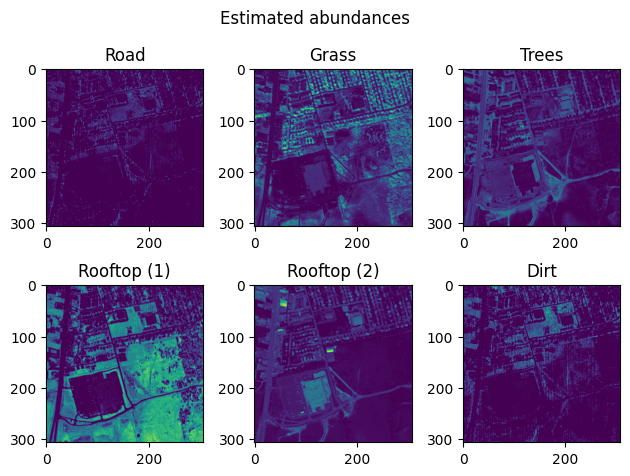

In [37]:
print("Evaluation criterion: ", evalCriterion(endmembers, W3_t))

# Plot the estimated abundances
plt.figure()
plt.suptitle('Estimated abundances')
for ii in range(6):
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(H3_t[ii,:].reshape(nCol,nRow))

    plt.title(endmember_names[ii])
plt.tight_layout()
plt.show()